In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# file locations
    #Csec
        #rho
Csec_rho_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/rho_per_gene/20230724_Csec_rho_per_gene_and_1e3flankingregions.tsv', sep='\t', index_col=0)
Csec_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/rho_per_gene/20230717_Csec_rho_exons_and_introns.tsv', sep='\t', index_col=0)
Csec_rho_exon_and_intron.columns = ['scaffold', 'source', 'featuretype', 'start', 'stop', 'n', 'strand', 'n2', 'ID', 'scaffold_alt', 'rho']
        #CpG
Csec_CpG_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/20230717_Csec_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t', index_col=0)
Csec_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/20230717_Csec_CpG_exons_and_introns.tsv', sep='\t', index_col=0)

    #Mbel
        #rho
Mbel_rho_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_rho_per_gene_and_1e3flankingregions.tsv', sep='\t',index_col=0)
Mbel_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_rho_exons_and_introns.tsv', sep='\t',index_col=0)
        #CpG
Mbel_CpG_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t',index_col=0)
Mbel_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t',index_col=0)


In [80]:
len(list(set(Mbel_rho_gene_and_flank.ID)))

30625

61250

In [81]:
len(Mbel_rho_gene_and_flank.ID)

61250

# format and merge _C. secundus_ tables

In [3]:
Csec_gene_and_flank = pd.merge(left=Csec_rho_gene_and_flank, right=Csec_CpG_gene_and_flank, left_on='idstring', right_on='ID')

In [4]:
Csec_exin = pd.merge(left=Csec_CpG_exon_and_intron, right=Csec_rho_exon_and_intron, left_on=['ID','featuretype'], right_on=['ID','featuretype'])

In [5]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [6]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [7]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [8]:
# remnove superfluous columns
Csec_gene_and_flank = Csec_gene_and_flank[['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID']]

In [9]:
# rename scaffold and rho columns to avoid issues down the line
Csec_exin.columns = ['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold2', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'scaffold', 'weighted_mean_rho_gene', 'GeneID']

In [10]:
# remnove superfluous columns
Csec_exin = Csec_exin[['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe','source', 'start', 'stop', 'n', 'strand', 'n2','scaffold', 'weighted_mean_rho_gene', 'GeneID']]

In [11]:
merged_Csec = pd.concat([Csec_gene_and_flank, Csec_exin])

In [12]:
#merged_Csec.to_csv('./20230727_Csec_rho_and_CpG_for_genes_flanking1e3_and_exons_introns.tsv', sep='\t')

# format and merge _M. bellicosus_ tables

In [13]:
Mbel_rho_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID']
Mbel_gene_and_flank = pd.merge(left=Mbel_rho_gene_and_flank, right=Mbel_CpG_gene_and_flank, left_on='ID', right_on='ID')
Mbel_exin = pd.merge(left=Mbel_CpG_exon_and_intron, right=Mbel_rho_exon_and_intron, left_on=['ID'], right_on=['ID'])

In [16]:
def split_id(ID, featuretype=False):
    gene =  ID.rsplit('.',1)[0]
    ft =  ID.rsplit('.',1)[1]
    if featuretype==True:
        #strip number of intron/exon id to get only the type
        return ''.join([i for i in ft if not i.isdigit()])
    else:
        return gene

In [17]:
Mbel_exin.columns = ['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype',
       'Start_pos', 'End_pos', 'GeneID', 'weighted_mean_rho_gene']

In [18]:
Mbel_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'GeneID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe']

In [70]:
merged_Mbel = pd.concat([Mbel_exin,Mbel_gene_and_flank])
merged_Mbel.featuretype = merged_Mbel.featuretype.replace(np.nan, 'gene')

In [20]:
#merged_Mbel.to_csv('./20230727_Mbel_rho_and_CpG_for_genes_flanking1e3_and_exons_introns.tsv', sep='\t')

# get differential expression data for M.bellicosus

In [83]:
DEdf = pd.read_csv('./Mbel/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)

In [84]:
from collections import Counter

In [85]:
DEdf = DEdf.dropna(subset=['sgo'])

In [86]:
DEdf.loc[DEdf.sgo==True]

,GeneID,DE,DE_royal,sgo,sgo_mbel,sgo_mnat,king_upregulated_vs_queen,majorworker_upregulated_vs_king,majorworker_upregulated_vs_queen,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
1,Mnat_01287,True,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,False,g7978.t1
2,Mnat_01288,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g7977.t1
3,Mnat_01289,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7976.t1
4,Mnat_01290,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7975.t1
6,Mnat_01292,True,True,True,True,True,True,False,True,False,False,False,False,False,True,False,False,True,g7972.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16259,Mnat_17703,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g16633.t2
16288,Mnat_17732,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g13792.t1
16294,Mnat_17738,True,True,True,True,True,False,False,False,True,True,True,False,False,False,False,True,False,g3158.t3
16296,Mnat_17739,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,g9829.t1


In [25]:
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']

In [47]:
Counter(DEdf.DE_royal)

Counter({False: 9243, True: 7067})

In [27]:
Counter(DEdf.DE)

Counter({False: 8980, True: 7330})

In [48]:
Counter(DEdf.loc[DEdf.sgo==True].DE)

Counter({True: 3535, False: 1864})

In [49]:
Counter(DEdf.loc[DEdf.sgo==True].DE_royal)

Counter({True: 3402, False: 1997})

In [30]:
o_n = []
for i, k in DEdf.iterrows():
    o_n.append(len(str(k.orthologues).split(';')))

#[np.nan if i==np.nan else len(i.split(';')) for i in  DEdf.orthologues]

In [31]:
import scipy.stats as scstats

In [32]:
DEdf[['DE_royal', 'sgo']]

,DE_royal,sgo
0,True,False
1,True,True
2,True,True
3,False,True
4,False,True
...,...,...
16305,True,False
16306,True,False
16307,False,False
16308,False,False


In [50]:
pd.crosstab(DEdf.DE_royal, DEdf.sgo)

sgo,False,True
DE_royal,,
False,7246,1997
True,3665,3402


In [51]:
DEdf.shape

(16310, 19)

In [52]:
from scipy.stats import fisher_exact
tab = pd.crosstab(DEdf.DE_royal, DEdf.sgo)
fisher_exact(tab)

SignificanceResult(statistic=3.3680660144377548, pvalue=3.2157758116575356e-279)

In [53]:
from scipy.stats import fisher_exact
tab = pd.crosstab(DEdf.DE, DEdf.sgo)
fisher_exact(tab)

SignificanceResult(statistic=3.5560484486590105, pvalue=3.7995066884027204e-303)

In [54]:
from scipy.stats import fisher_exact
tab = pd.crosstab(DEdf.minorworker_upregulated_vs_queen, DEdf.sgo)
fisher_exact(tab)

SignificanceResult(statistic=1.2494358931728762, pvalue=1.505348690781031e-07)

In [55]:
from scipy.stats import fisher_exact
tab = pd.crosstab(DEdf.queen_upregulated_vs_minorworker, DEdf.sgo)
fisher_exact(tab)

SignificanceResult(statistic=3.714778872433367, pvalue=6.050920331988237e-199)

In [56]:
#?scstats.chi2_contingency

In [57]:
#g, p, dof, expctd = chi2_contingency(obs, lambda_="log-likelihood")

In [58]:
DEdf

,GeneID_Mnat,DE,DE_royal,sgo,sgo_mbel,sgo_mnat,king_upregulated_vs_queen,majorworker_upregulated_vs_king,majorworker_upregulated_vs_queen,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
0,Mnat_01286,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,g18888.t1
1,Mnat_01287,True,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,False,g7978.t1
2,Mnat_01288,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g7977.t1
3,Mnat_01289,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7976.t1
4,Mnat_01290,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7975.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16305,Mnat_17749,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,NaN
16306,Mnat_17750,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,NaN
16307,Mnat_17751,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,g7618.t1
16308,Mnat_17752,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,g8842.t1;g9672.t1


In [66]:
DE_sgo = DEdf.loc[DEdf.sgo==True]

In [67]:
DE_sgo

,GeneID_Mnat,DE,DE_royal,sgo,sgo_mbel,sgo_mnat,king_upregulated_vs_queen,majorworker_upregulated_vs_king,majorworker_upregulated_vs_queen,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
1,Mnat_01287,True,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,False,g7978.t1
2,Mnat_01288,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g7977.t1
3,Mnat_01289,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7976.t1
4,Mnat_01290,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7975.t1
6,Mnat_01292,True,True,True,True,True,True,False,True,False,False,False,False,False,True,False,False,True,g7972.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16259,Mnat_17703,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g16633.t2
16288,Mnat_17732,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g13792.t1
16294,Mnat_17738,True,True,True,True,True,False,False,False,True,True,True,False,False,False,False,True,False,g3158.t3
16296,Mnat_17739,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,g9829.t1


In [73]:
DE_sgo

,GeneID_Mnat,DE,DE_royal,sgo,sgo_mbel,sgo_mnat,king_upregulated_vs_queen,majorworker_upregulated_vs_king,majorworker_upregulated_vs_queen,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
1,Mnat_01287,True,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,False,g7978.t1
2,Mnat_01288,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g7977.t1
3,Mnat_01289,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7976.t1
4,Mnat_01290,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g7975.t1
6,Mnat_01292,True,True,True,True,True,True,False,True,False,False,False,False,False,True,False,False,True,g7972.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16259,Mnat_17703,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,g16633.t2
16288,Mnat_17732,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,g13792.t1
16294,Mnat_17738,True,True,True,True,True,False,False,False,True,True,True,False,False,False,False,True,False,g3158.t3
16296,Mnat_17739,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,g9829.t1


In [71]:
DE_Mbel = merged_Mbel.merge(DE_sgo, left_on='GeneID', right_on='orthologues')

In [72]:
DE_Mbel.loc[DE_Mbel.featuretype=="gene"]

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
19,NaN,801.712270,271,0.338027,scaffold5,gene,NaN,NaN,g4861.t1,0.239032320305399,...,True,True,False,False,True,False,True,True,False,g4861.t1
20,NaN,801.712270,271,0.338027,scaffold5,gene,NaN,NaN,g4861.t1,0.239032320305399,...,True,True,False,False,True,False,True,True,False,g4861.t1
42,NaN,300.919885,90,0.299083,scaffold23,gene,NaN,NaN,g14208.t1,0.073184939481268,...,False,False,False,False,False,False,False,False,False,g14208.t1
43,NaN,300.919885,90,0.299083,scaffold23,gene,NaN,NaN,g14208.t1,0.073184939481268,...,False,False,False,False,False,False,False,False,False,g14208.t1
53,NaN,289.145672,110,0.380431,scaffold9,gene,NaN,NaN,g4158.t1,0.029207642505277975,...,False,False,False,False,False,False,False,False,False,g4158.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100537,NaN,471.484655,435,0.922618,scaffold63,gene,NaN,NaN,g7147.t1,4.4665880838979675,...,True,True,True,False,True,False,False,False,False,g7147.t1
100541,NaN,525.257261,484,0.921453,scaffold9,gene,NaN,NaN,g4046.t1,0.5629005700883997,...,False,False,False,False,False,False,False,False,False,g4046.t1
100542,NaN,525.257261,484,0.921453,scaffold9,gene,NaN,NaN,g4046.t1,0.5629005700883997,...,False,False,False,False,False,False,False,False,False,g4046.t1
100562,NaN,569.280749,233,0.409288,scaffold11,gene,NaN,NaN,g2881.t1,0.2457575708673315,...,False,False,False,False,False,False,False,False,False,g2881.t1


In [40]:
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_majorworker)

Counter({False: 8852, True: 1946})

In [31]:
#Counter(DE_Mbel.featuretype)

In [43]:
Counter(DE_sgo.loc[DE_sgo.featuretype=='gene'].queen_upregulated_vs_majorworker)

AttributeError: 'DataFrame' object has no attribute 'featuretype'

In [48]:
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)

In [49]:
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)

In [50]:
DE_Mbel.columns

Index(['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold',
       'featuretype', 'Start_pos', 'End_pos', 'GeneID',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues'],
      dtype='object')

In [51]:
DE_Mbel.loc[DE_Mbel.sgo==True].columns

Index(['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold',
       'featuretype', 'Start_pos', 'End_pos', 'GeneID',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues'],
      dtype='object')

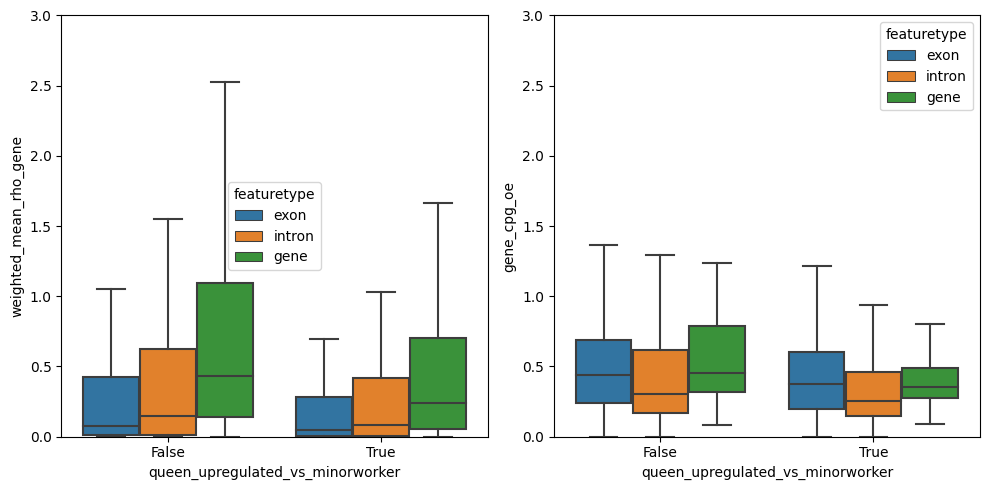

In [52]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='queen_upregulated_vs_minorworker', hue='featuretype', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='queen_upregulated_vs_minorworker', hue='featuretype', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
plt.tight_layout()
plt.show()

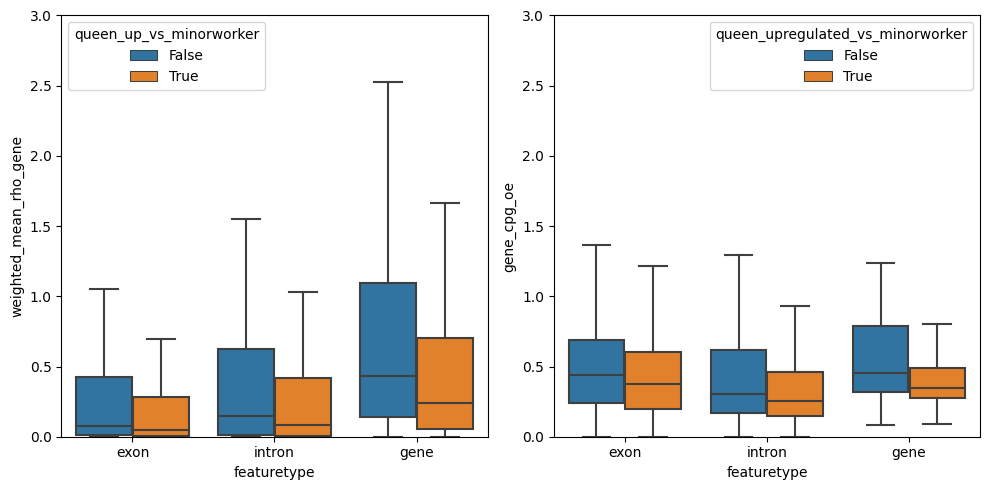

In [50]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='queen_up_vs_minorworker', loc='upper left')

plt.tight_layout()
plt.show()

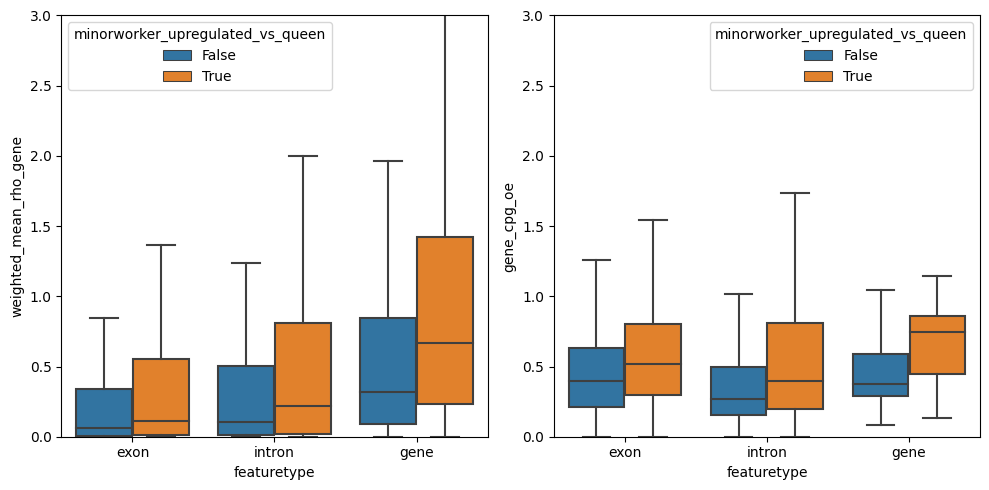

In [54]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='minorworker_upregulated_vs_queen', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='minorworker_upregulated_vs_queen', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='minorworker_upregulated_vs_queen', loc='upper left')

plt.tight_layout()
plt.show()

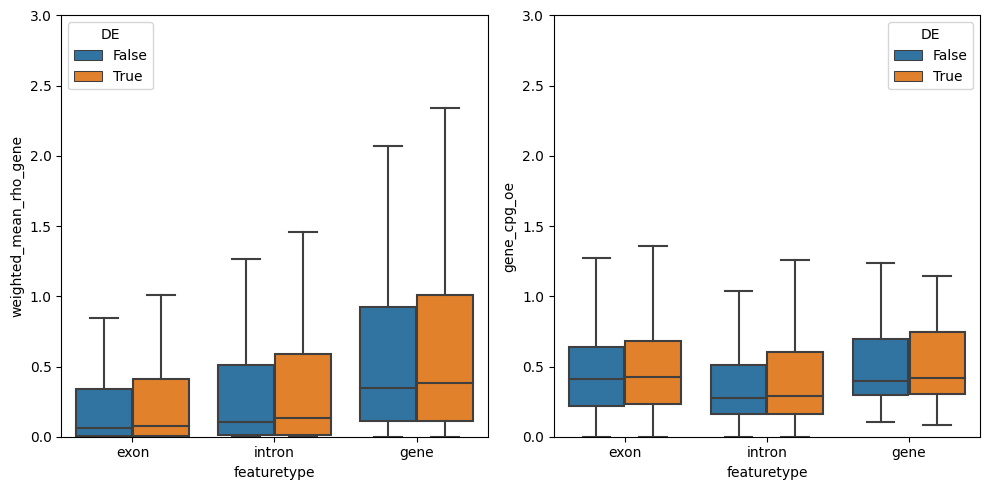

In [52]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='DE', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='DE', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='DE', loc='upper left')

plt.tight_layout()
plt.show()

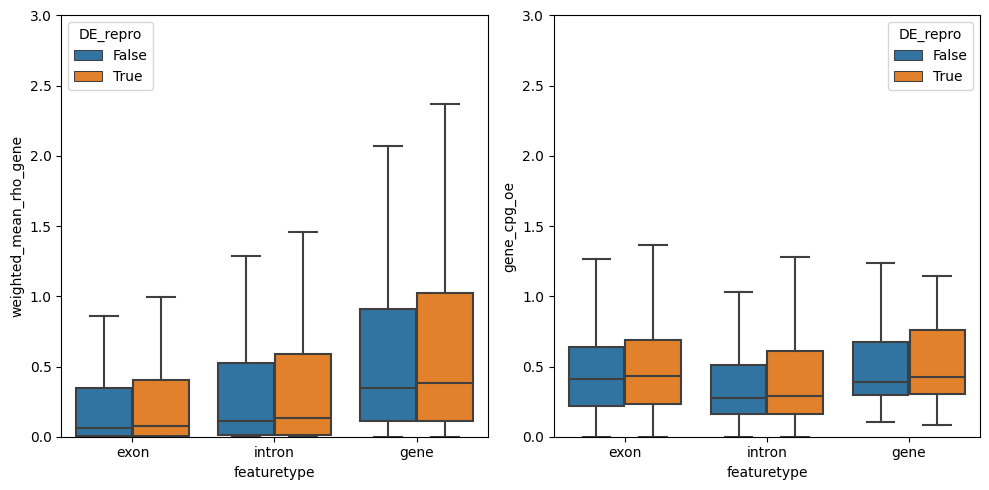

In [194]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='DE_royal', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='DE_royal', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='DE_repro', loc='upper left')
ax1.legend(title='DE_repro', loc='upper right')

plt.tight_layout()
plt.show()

Counter({False: 3848, True: 1551})

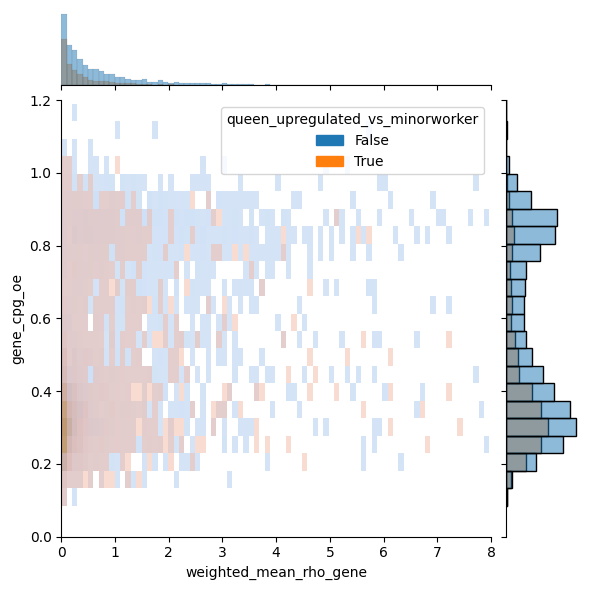

In [200]:
sns.jointplot(data=DE_Mbel.loc[DE_Mbel.featuretype=='gene'],y='gene_cpg_oe', x='weighted_mean_rho_gene', hue='queen_upregulated_vs_minorworker', kind='hist', alpha=0.5 )
plt.ylim(0,1.2)
plt.xlim(0,8)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_minorworker)


Counter({False: 3848, True: 1551})

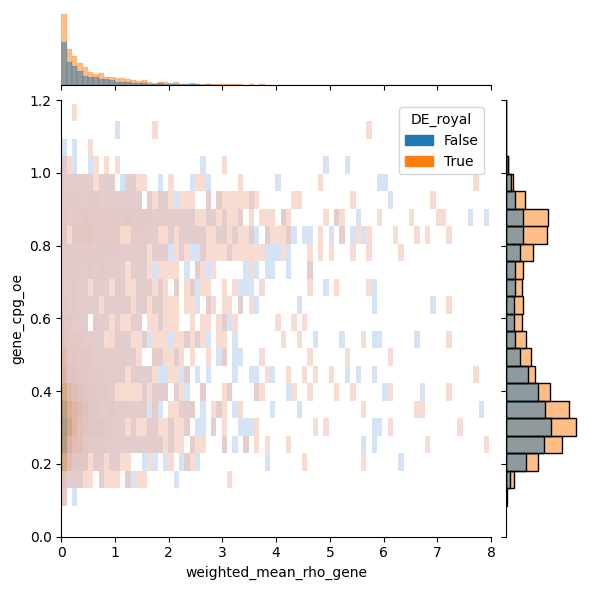

In [198]:
sns.jointplot(data=DE_Mbel.loc[DE_Mbel.featuretype=='gene'],y='gene_cpg_oe', x='weighted_mean_rho_gene', hue='DE_royal', kind='hist', alpha=0.5 )
plt.ylim(0,1.2)
plt.xlim(0,8)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_minorworker)


Counter({False: 3848, True: 1551})

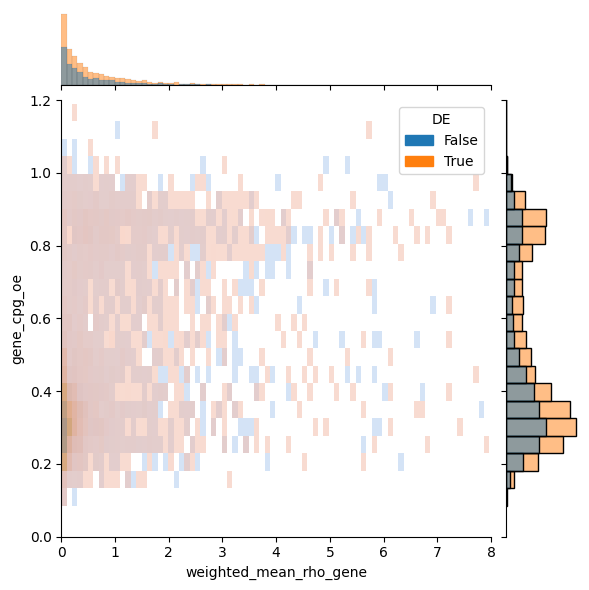

In [199]:
sns.jointplot(data=DE_Mbel.loc[DE_Mbel.featuretype=='gene'],y='gene_cpg_oe', x='weighted_mean_rho_gene', hue='DE', kind='hist', alpha=0.5 )
plt.ylim(0,1.2)
plt.xlim(0,8)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_minorworker)


Counter({False: 3848, True: 1551})

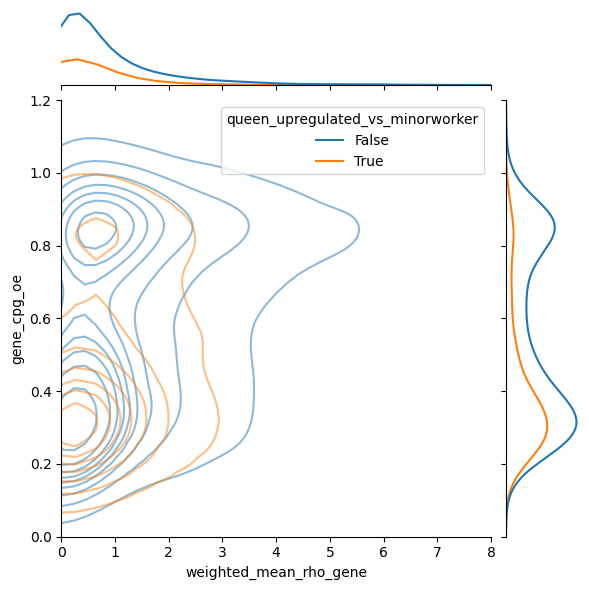

In [78]:
sns.jointplot(data=DE_Mbel.loc[DE_Mbel.featuretype=='gene'],y='gene_cpg_oe', x='weighted_mean_rho_gene', hue='queen_upregulated_vs_minorworker', kind='kde', alpha=0.5 )
plt.ylim(0,1.2)
plt.xlim(0,8)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_minorworker)


/home/tilman/miniconda3/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'dodge', 'fliersize'
  cset = contour_func(


Counter({False: 3848, True: 1551})

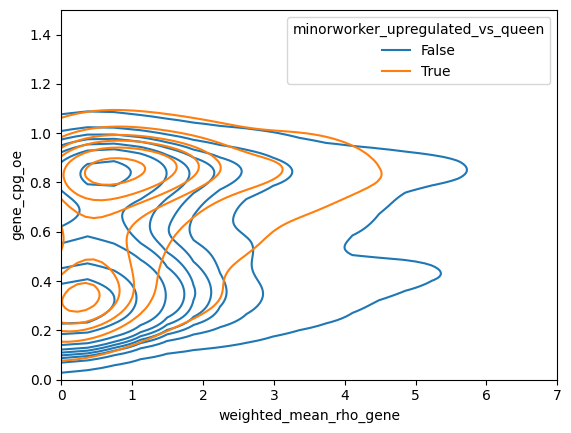

In [65]:
sns.kdeplot(data=DE_Mbel.loc[DE_Mbel.featuretype=='gene'],y='gene_cpg_oe', x='weighted_mean_rho_gene', hue='minorworker_upregulated_vs_queen', dodge=True, fliersize=0) 
plt.ylim(0,1.5)
plt.xlim(0,7)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_minorworker)


Counter({False: 4426, True: 973})

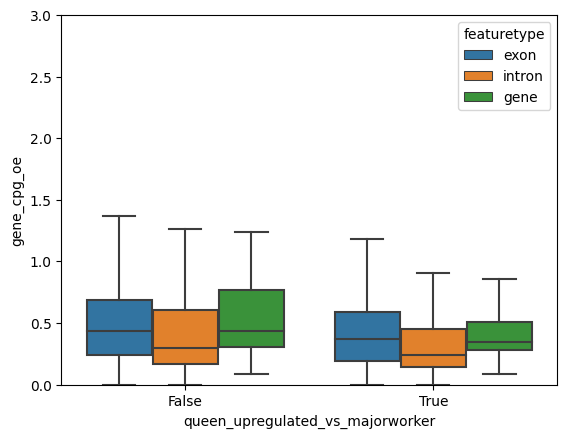

In [58]:
sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='queen_upregulated_vs_majorworker', hue='featuretype', dodge=True, fliersize=0) 
plt.ylim(0,3)
Counter(DE_Mbel.loc[DE_Mbel.featuretype=='gene'].queen_upregulated_vs_majorworker)


In [55]:
DE_Mbel_exin = DE_Mbel.loc[DE_Mbel.featuretype.isin(['exon', 'intron'])]

In [56]:
DE_Mbel.weighted_mean_rho_uflank = DE_Mbel.weighted_mean_rho_uflank.astype(float)
DE_Mbel.weighted_mean_rho_dflank = DE_Mbel.weighted_mean_rho_dflank.astype(float)

In [57]:
DE_Mbel_exin

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
0,g4861.t1.exon1,0.857143,0,0.000000,scaffold5,exon,17622247.0,17622261.0,g4861.t1,2.278240,...,True,True,False,False,True,False,True,True,False,g4861.t1
1,g4861.t1.intron1,125.690391,86,0.684221,scaffold5,intron,17622262.0,17625634.0,g4861.t1,1.652539,...,True,True,False,False,True,False,True,True,False,g4861.t1
2,g4861.t1.exon2,6.967742,1,0.143519,scaffold5,exon,17625635.0,17625790.0,g4861.t1,0.010810,...,True,True,False,False,True,False,True,True,False,g4861.t1
3,g4861.t1.intron2,38.965517,9,0.230973,scaffold5,intron,17625791.0,17626951.0,g4861.t1,0.008107,...,True,True,False,False,True,False,True,True,False,g4861.t1
4,g4861.t1.exon3,5.657143,1,0.176768,scaffold5,exon,17626952.0,17627057.0,g4861.t1,0.006560,...,True,True,False,False,True,False,True,True,False,g4861.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95159,g2881.t1.exon8,2.302326,0,0.000000,scaffold11,exon,28563444.0,28563530.0,g2881.t1,0.133400,...,False,False,False,False,False,False,False,False,False,g2881.t1
95160,g2881.t1.intron8,26.697303,6,0.224742,scaffold11,intron,28563531.0,28564532.0,g2881.t1,1.625669,...,False,False,False,False,False,False,False,False,False,g2881.t1
95161,g2881.t1.exon9,4.413043,0,0.000000,scaffold11,exon,28564533.0,28564625.0,g2881.t1,1.808020,...,False,False,False,False,False,False,False,False,False,g2881.t1
95162,g2881.t1.intron9,55.170732,18,0.326260,scaffold11,intron,28564626.0,28566676.0,g2881.t1,0.292779,...,False,False,False,False,False,False,False,False,False,g2881.t1


In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
?smf

Type:        module
String form: <module 'statsmodels.formula.api' from '/home/tilman/miniconda3/lib/python3.10/site-packages/statsmodels/formula/api.py'>
File:        ~/miniconda3/lib/python3.10/site-packages/statsmodels/formula/api.py
Docstring:   <no docstring>

In [60]:
mod = smf.ols(formula='gene_cpg_oe ~ DE_royal * featuretype', data=DE_Mbel_exin)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            gene_cpg_oe   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     559.6
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:00:37   Log-Likelihood:                -30884.
No. Observations:               89766   AIC:                         6.178e+04
Df Residuals:                   89762   BIC:                         6.181e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [61]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ gene_cpg_oe * DE_royal * featuretype', data=DE_Mbel_exin, )
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     weighted_mean_rho_gene   R-squared:                       0.011
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     143.4
Date:                    Thu, 03 Aug 2023   Prob (F-statistic):          2.99e-211
Time:                            14:01:44   Log-Likelihood:            -2.0160e+05
No. Observations:                   86365   AIC:                         4.032e+05
Df Residuals:                       86357   BIC:                         4.033e+05
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [65]:
print(res.get_robustcov_results(cov_type='HC1', use_t=None).summary())

                              OLS Regression Results                              
Dep. Variable:     weighted_mean_rho_gene   R-squared:                       0.011
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     91.71
Date:                    Thu, 03 Aug 2023   Prob (F-statistic):          7.17e-134
Time:                            14:13:16   Log-Likelihood:            -2.0160e+05
No. Observations:                   86365   AIC:                         4.032e+05
Df Residuals:                       86357   BIC:                         4.033e+05
Df Model:                               7                                         
Covariance Type:                      HC1                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

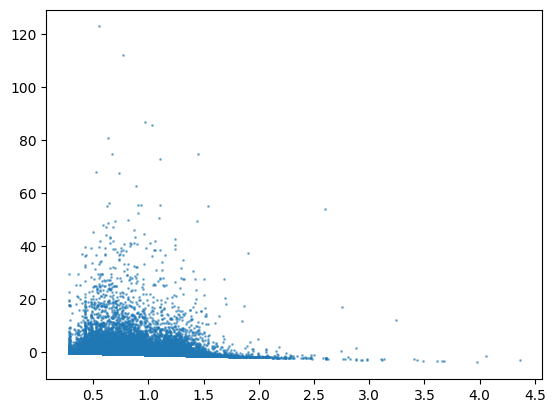

In [73]:
plt.scatter(x=res.fittedvalues, y=res.resid, s=1, alpha=0.5)

In [89]:
val_and_fit = pd.DataFrame([DE_Mbel_exin.gene_cpg_oe, res.fittedvalues]).T

In [91]:
#plt.scatter(y=val_and_fit['Unnamed 0'], x=val_and_fit.gene_cpg_oe, s=1)

In [ ]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ DE_royal * featuretype', data=DE_Mbel_exin)
res = mod.fit()
print(res.summary())

In [327]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ (DE_royal + DE) * (featuretype + scaffold)', data=DE_Mbel_exin)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     weighted_mean_rho_gene   R-squared:                       0.025
Model:                                OLS   Adj. R-squared:                  0.023
Method:                     Least Squares   F-statistic:                     9.010
Date:                    Tue, 01 Aug 2023   Prob (F-statistic):          2.22e-312
Time:                            17:36:25   Log-Likelihood:            -2.0099e+05
No. Observations:                   86365   AIC:                         4.025e+05
Df Residuals:                       86115   BIC:                         4.048e+05
Df Model:                             249                                         
Covariance Type:                nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ (scaffold  + king_upregulated_vs_queen + majorworker_upregulated_vs_king + majorworker_upregulated_vs_queen + queen_upregulated_vs_king + queen_upregulated_vs_majorworker + king_upregulated_vs_majorworker + minorworker_upregulated_vs_majorworker + king_upregulated_vs_minorworker + minorworker_upregulated_vs_king + majorworker_upregulated_vs_minorworker + queen_upregulated_vs_minorworker + minorworker_upregulated_vs_queen) * featuretype', data=DE_Mbel_exin)
res = mod.fit()
print(res.summary())

In [326]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ (scaffold + weighted_mean_rho_gene + king_upregulated_vs_queen + majorworker_upregulated_vs_king + majorworker_upregulated_vs_queen + queen_upregulated_vs_king + queen_upregulated_vs_majorworker + king_upregulated_vs_majorworker + minorworker_upregulated_vs_majorworker + king_upregulated_vs_minorworker + minorworker_upregulated_vs_king + majorworker_upregulated_vs_minorworker + queen_upregulated_vs_minorworker + minorworker_upregulated_vs_queen) * featuretype', data=DE_Mbel_exin)
res = mod.fit()
print(res.summary())

KeyboardInterrupt: 

In [328]:
mod = smf.mixedlm(formula='weighted_mean_rho_gene ~ DE_royal ', data=DE_Mbel_exinnona, groups=['featuretype', 'scaffold'])
res = mod.fit()
print(res.summary())

ValueError: operands could not be broadcast together with shapes (86365,1) (2,1) 

In [313]:
print(' + '.join([ 'scaffold',
       'weighted_mean_rho_gene','king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',]))

scaffold + weighted_mean_rho_gene + king_upregulated_vs_queen + majorworker_upregulated_vs_king + majorworker_upregulated_vs_queen + queen_upregulated_vs_king + queen_upregulated_vs_majorworker + king_upregulated_vs_majorworker + minorworker_upregulated_vs_majorworker + king_upregulated_vs_minorworker + minorworker_upregulated_vs_king + majorworker_upregulated_vs_minorworker + queen_upregulated_vs_minorworker + minorworker_upregulated_vs_queen


In [286]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm


In [249]:

DE_Mbel_exin.isna().sum()

ID                                            0
gene_cpg_e                                    0
gene_cpg_o                                    0
gene_cpg_oe                                   0
scaffold                                      0
featuretype                                   0
Start_pos                                     0
End_pos                                       0
GeneID                                        0
weighted_mean_rho_gene                     3401
weighted_mean_rho_uflank                  89766
weighted_mean_rho_dflank                  89766
flank_u_cpg_e                             89766
flank_u_cpg_o                             89766
flank_u_cpg_oe                            89766
flank_d_cpg_e                             89766
flank_d_cpg_o                             89766
flank_d_cpg_oe                            89766
GeneID_Mnat                                   0
DE                                            0
DE_royal                                

In [252]:
DE_Mbel_exinnona = DE_Mbel_exin.dropna(subset=['weighted_mean_rho_gene'])

In [240]:
DE_Mbel_exin.weighted_mean_rho_gene.isna().sum()

3401

In [253]:
scstats.spearmanr(a=DE_Mbel_exinnona.weighted_mean_rho_gene, b=DE_Mbel_exinnona.minorworker_upregulated_vs_queen)

SignificanceResult(statistic=0.08506205782016045, pvalue=2.0806782603545444e-138)

In [255]:
scstats.spearmanr(a=DE_Mbel_exinnona.gene_cpg_oe, b=DE_Mbel_exinnona.minorworker_upregulated_vs_queen)

SignificanceResult(statistic=0.14617010313426335, pvalue=0.0)

In [ ]:
scstats.spearmanr(a=DE_Mbel_exinnona.gene_cpg_oe, b=DE_Mbel_exinnona.minorworker_upregulated_vs_queen)

In [256]:
scstats.spearmanr(a=DE_Mbel_exinnona.gene_cpg_oe, b=DE_Mbel_exinnona.DE)

SignificanceResult(statistic=0.04015915215950735, pvalue=3.611512871199391e-32)

In [257]:
scstats.spearmanr(a=DE_Mbel_exinnona.weighted_mean_rho_gene, b=DE_Mbel_exinnona.DE)

SignificanceResult(statistic=0.030860974815972702, pvalue=1.1746654840570903e-19)

In [282]:
sgo_DEr_ex = DE_Mbel_exinnona.loc[DE_Mbel_exinnona.sgo==True].loc[DE_Mbel_exinnona.DE_royal==True].loc[DE_Mbel_exinnona.featuretype=='exon'].gene_cpg_oe
sgo_DEr_in = DE_Mbel_exinnona.loc[DE_Mbel_exinnona.sgo==True].loc[DE_Mbel_exinnona.DE_royal==True].loc[DE_Mbel_exinnona.featuretype=='intron'].gene_cpg_oe


sgo_nDEr_ex = DE_Mbel_exinnona.loc[DE_Mbel_exinnona.sgo==True].loc[DE_Mbel_exinnona.DE_royal==False].loc[DE_Mbel_exinnona.featuretype=='exon'].gene_cpg_oe
sgo_nDEr_in = DE_Mbel_exinnona.loc[DE_Mbel_exinnona.sgo==True].loc[DE_Mbel_exinnona.DE_royal==False].loc[DE_Mbel_exinnona.featuretype=='intron'].gene_cpg_oe

In [285]:
scstats.kruskal(sgo_DEr_ex,sgo_DEr_in,sgo_nDEr_ex,sgo_nDEr_in, nan_policy='omit', axis=0, keepdims=False)

KruskalResult(statistic=1815.6622733272798, pvalue=0.0)

In [281]:
nsgo_nDEr_ex

Series([], Name: gene_cpg_oe, dtype: float64)

In [275]:
nsgo_DEr_ex

Series([], Name: gene_cpg_oe, dtype: float64)

In [283]:
#scipy.stats.kruskal(*samples, nan_policy='omit', axis=0, keepdims=False)